https://www.kaggle.com/code/romankholodkov/car-prices-prediction

### Price car prediction

We can find out the market price of a car.
We will build different models that know how to determine it (the simple model and the gradient boosting ones). The RMSE measure will show us which model works better.

There are data on the technical characteristics, equipment and prices of other vehicles:

* DateCrawled — date of downloading the questionnaire from the database;

* VehicleType — car body type;

* RegistrationYear — year of car registration;

* Gearbox — gearbox type;

* Power — power (hp);

* Model — car model;

* Kilometer — mileage (km);

* RegistrationMonth — month of car registration;

* FuelType — fuel type;

* Brand — car brand;

* Repaired — was the car under repair or not;

* DateCreated — date of creation of the questionnaire;

* NumberOfPictures — number of car's pictures;

* PostalCode — user's postal code;

* LastSeen — date of last user activity.


Response variable, target:

    Price — car price (euro).

## 1. Data preparation

In [1]:
import pandas as pd 
import numpy as np
import scipy
from scipy import stats as st
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler 
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/kaggle/input/car-price-prediction/autos.csv')

In [3]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#missing data
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
#percentage of missing data
data.isnull().sum() / len(data) * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [8]:
data['VehicleType'].value_counts() 

VehicleType
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

In [9]:
data['Gearbox'].value_counts()

Gearbox
manual    268251
auto       66285
Name: count, dtype: int64

In [10]:
data['Model'].value_counts()

Model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

In [11]:
data['FuelType'].value_counts()

FuelType
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

In [12]:
data['Repaired'].value_counts()

Repaired
no     247161
yes     36054
Name: count, dtype: int64

In [13]:
#we fill in the missing values (around 11%) in the 'vehicle type' column, around 9 % in the 'fuel type' column and around 6 % in the 'gearbox' one 
#with the most popular ones in the columns

data['VehicleType'] = data['VehicleType'].fillna('sedan')
data['Gearbox'] = data['Gearbox'].fillna('manual')
data['FuelType'] = data['FuelType'].fillna('petrol')

#instead of nan (around 6%) in the 'model' column let's leave blanks
#instead of nan (around 20%) in the 'repaired' column let's leave blanks
data['Model'] = data['Model'].fillna('')
data['Repaired'] = data['Repaired'].fillna('')

In [14]:
data.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [15]:
#let's check out the duplicates
data.duplicated().sum()

4

In [16]:
data = data.drop_duplicates()

In [17]:
data.duplicated().sum()

0

Let's remove the date factors, they do not contain business information, we do not need them to build models. 

Let's also remove the column with the number of photos. It has only 0 for each line, it will not give us any useful information, just like the column with the postal codes of customers.

In [18]:
del data['DateCrawled']
del data['RegistrationYear']
del data['RegistrationMonth']
del data['DateCreated']
del data['LastSeen']
del data['NumberOfPictures']
del data['PostalCode']

In [19]:
#we can check if there is any non-informative data of the target feature that less than or equal to zero

len(data.query('Price <= 0'))

10772

In [20]:
#let's leave only cars with the price more than 0

data = data.query('Price > 0')

In [21]:
data.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,manual,0,golf,150000,petrol,volkswagen,
1,18300,coupe,manual,190,,125000,gasoline,audi,yes
2,9800,suv,auto,163,grand,125000,gasoline,jeep,
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343593 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Price        343593 non-null  int64 
 1   VehicleType  343593 non-null  object
 2   Gearbox      343593 non-null  object
 3   Power        343593 non-null  int64 
 4   Model        343593 non-null  object
 5   Kilometer    343593 non-null  int64 
 6   FuelType     343593 non-null  object
 7   Brand        343593 non-null  object
 8   Repaired     343593 non-null  object
dtypes: int64(3), object(6)
memory usage: 26.2+ MB


So, in the original dataframe there are 354369 rows, 16 columns, of which 7 columns with the numeric data type int64, 9 columns with the text data type object, 4 duplicates were found and removed, about 10,000 cars were with an uninformative price equal to 0, we filtered out such cars, as well as removed non-informative columns with dates that do not affect the business result, and columns with the number of photos and postal codes of customers. We found a fairly large number of missing values in categorical variables, some of which were left as blanks instead of the nan value itself, and some were replaced with the most popular values for a specific column. The final dataframe has 343593 rows and 9 columns with information about cars: 3 numeric features (price, power, kilometer) and 6 text features (vehicle type, gearbox type, car model, fuel type, car brand, was the car under repair or not)). 

## EDA

Let's first check whether our target variable well distributed or not

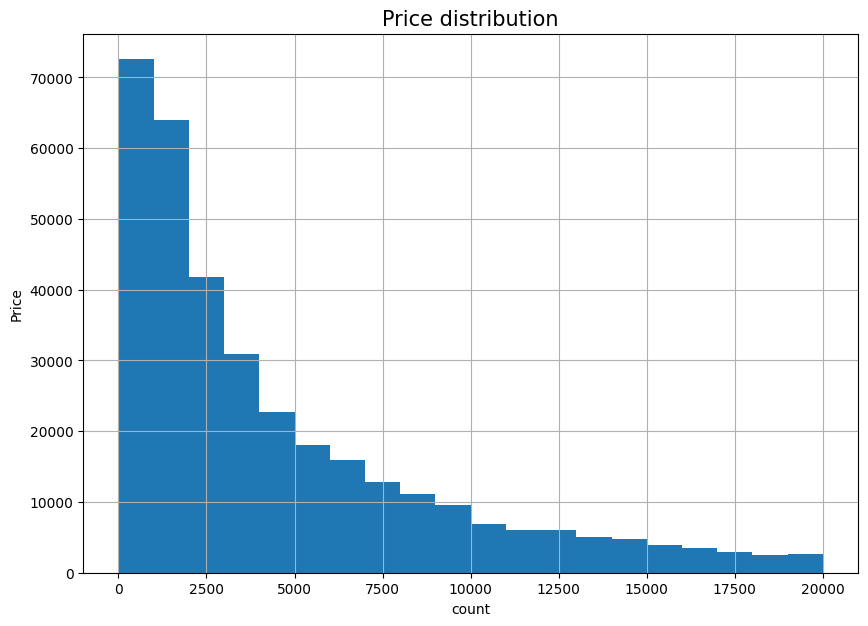

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [23]:
data['Price'].hist(bins=20, range = (0, 20000), figsize=(10, 7))
plt.xlabel('count')
plt.ylabel('Price')
plt.title('Price distribution', fontsize = 15)
plt.show();

data['Price'].describe()

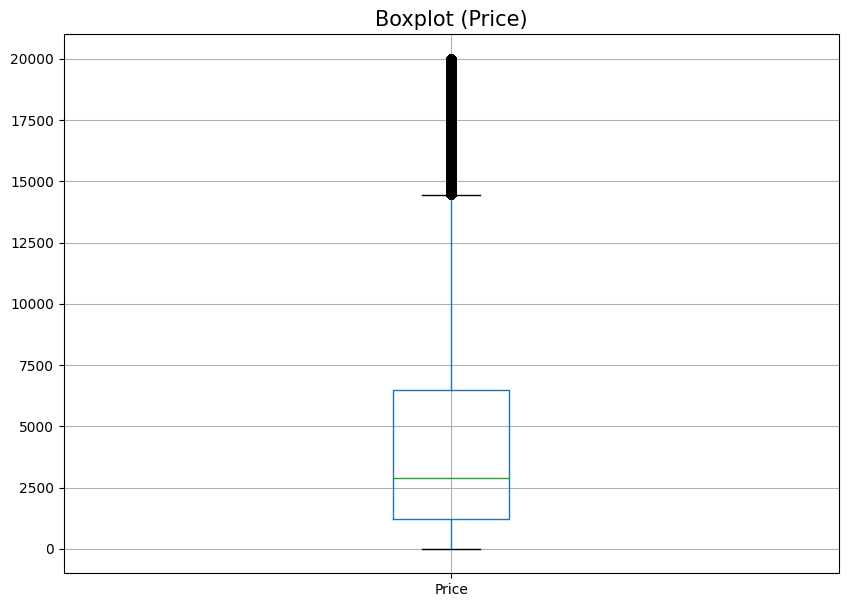

In [24]:
data.boxplot('Price', figsize=(10,7)).set_title('Boxplot (Price)', fontsize=15);

The median value of the price is about 2890 euros per car, the average is about 4555 euros. 75 % of values - up to 6500 euros, but the maximum value is 20000 euros, there are rare values - cars that cost more than 14000 euros.

In [25]:
data.query('Price > 14000')

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,manual,190,,125000,gasoline,audi,yes
8,14500,bus,manual,125,c_max,30000,petrol,ford,
14,17999,suv,manual,190,navara,70000,gasoline,nissan,no
33,18000,sedan,auto,218,3er,20000,petrol,bmw,no
50,14800,convertible,manual,170,1er,125000,petrol,bmw,
...,...,...,...,...,...,...,...,...,...
354259,15000,sedan,auto,115,focus,60000,gasoline,ford,no
354279,16500,suv,manual,116,i_reihe,30000,gasoline,hyundai,no
354286,16500,coupe,manual,200,other,150000,petrol,bmw,yes
354306,16999,wagon,auto,269,a6,150000,gasoline,audi,no


VehicleType
sedan          123155
small           78017
wagon           63700
bus             28345
convertible     19865
coupe           15634
suv             11791
other            3086
Name: count, dtype: int64


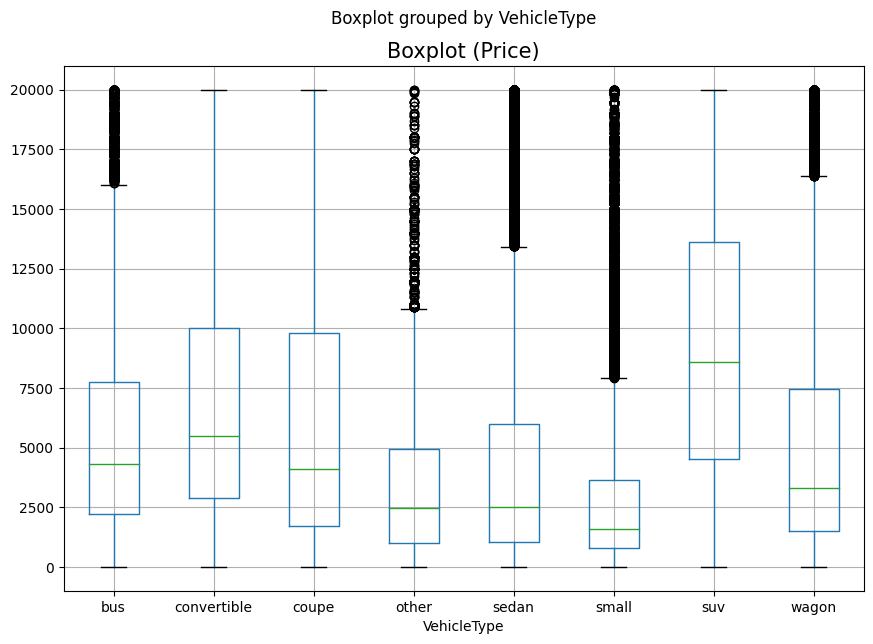

In [26]:
#checking how the price is distributed depending on the type of the vehicle type

data.boxplot('Price', 'VehicleType', figsize=(10,7)).set_title('Boxplot (Price)', fontsize=15);


print(data['VehicleType'].value_counts())

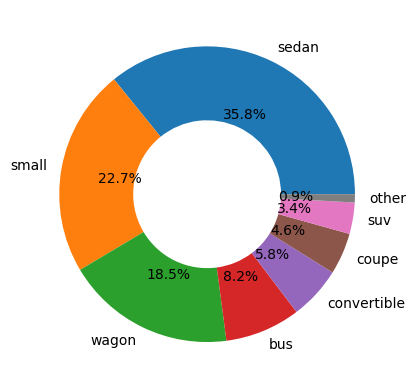

In [27]:
vals = [123155, 78017, 63700, 28345, 19865, 15634, 11791, 3086]
labels = ["sedan", "small", "wagon", "bus", "convertible", "coupe", "suv", "other"]
fig, ax = plt.subplots();
ax.pie(vals, labels=labels, autopct='%1.1f%%', wedgeprops=dict(width=0.5));

Almost 1/3 of the dataset (about 36%, or 123,155 ads) are cars with a sedan body type. About 23%, or 78,017 advertisements, are small cars, about 19%, or 63,700 advertisements, are wagons.
According to the boxplot chart, the distribution of prices for these categories is as follows: the lowest median prices are for cars with a sedan body type, small cars and the “other” category, the highest are for SUVs.

In [28]:
#Let's check the first hypothesis: the average price of the most popular cars with a sedan body type and the average price of other cars differ.
#Let's formulate the null hypothesis H₀ (must be represented with an equal sign): the average price of cars in the first group is equal to the average price of cars in the second group.
#Let's formulate an alternative hypothesis (it will be two-sided) H₁: the average price of cars of the first type is not equal (more or less) to the average price of cars of the second group.
#Let's conduct a test for the hypothesis about the equality of two general populations.


data_sedan = data.query('VehicleType == "sedan"')['Price']
data_other = data.query('VehicleType != "sedan"')['Price']

print('Price variance of the most popular type of cars - sedan:', np.var(data_sedan))
print('Price variance of other car body types:', np.var(data_other))

print('Standard Deviation of price in the first group:', np.std(data_sedan))
print('Standard Deviation of price in the second group:', np.std(data_other))

alpha = .01 
# we will indicate the level of statistical significance (1%), which will mean that no more than a 1% probability of error is allowed. Those. the null hypothesis can be rejected in favor
# alternative hypothesis, if according to the results of the statistical test the probability
# errors, i.e. the probability of a random occurrence of the detected difference does not exceed 1 in 100, i.e. there is only a 1 in 100 chance of being wrong. If
# this level of significance is not achieved (the probability of error is higher than 1%), we consider
# that the difference may well be due to chance and therefore cannot be rejected as null
# hypothesis

results = st.ttest_ind(data_sedan, data_other, equal_var = False) 

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Do not accept the null hypothesis")
else:
    print("We can't reject the null hypothesis")
    
    
print('Price mean in the first group:', data_sedan.mean())
print('Price mean in the second group:', data_other.mean())

Price variance of the most popular type of cars - sedan: 18892397.704082713
Price variance of other car body types: 21128295.392197
Standard Deviation of price in the first group: 4346.538588817855
Standard Deviation of price in the second group: 4596.552555143583
p-value: 2.4575935854051103e-225
Do not accept the null hypothesis
Price mean in the first group: 4230.239576143884
Price mean in the second group: 4736.667874867309


With a 99% probability we can say that the average price of cars with the sedan body type is not equal to the average price of the group of other cars. The price variance of cars of the second group is higher, the standard deviation is also higher (by about 250 euros), the average price of the second group is about 4737 euros, which is about 500 euros more in comparison with cars with a sedan body type.

Gearbox
manual    278726
auto       64867
Name: count, dtype: int64


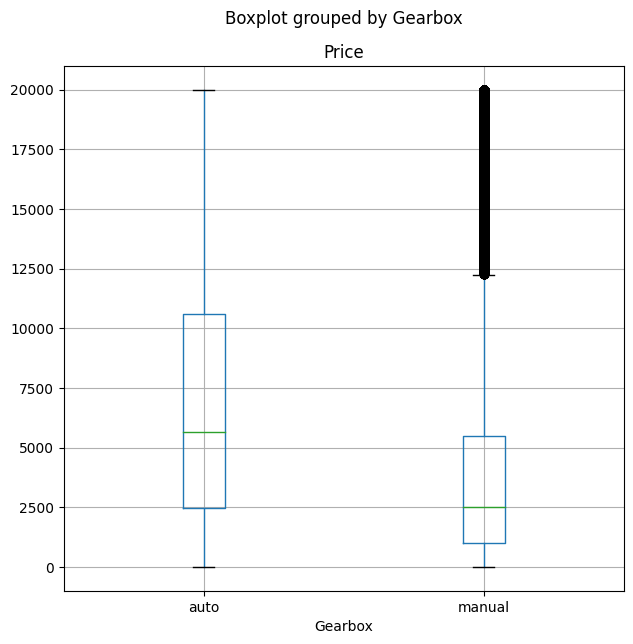

In [29]:
#Price and type of gearbox (quantity-category)

print(data['Gearbox'].value_counts())

data.boxplot('Price', 'Gearbox', figsize=(7,7));


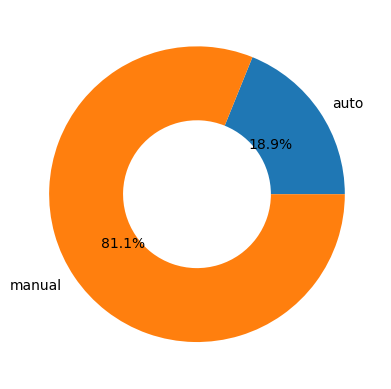

In [30]:
vals = [64867, 278726]
labels = ["auto", "manual"]
fig, ax = plt.subplots();
ax.pie(vals, labels=labels, autopct='%1.1f%%', wedgeprops=dict(width=0.5));

Cars with manual transmission - 278,726 (about 81%), with automatic - 64,867 (about 19%). The median price of cars with a manual transmission is about 2,500 euros, with an automatic transmission - about 5,500 euros.

In [31]:
#Let's check the second hypothesis: the average price of the most popular cars with a manual transmission and the average price of cars with an automatic transmission differ.
#Let's formulate the null hypothesis H₀ (must be represented with an equal sign): the average price of cars in the first group is equal to the average price of cars in the second group.
#Let's formulate an alternative hypothesis (it will be two-sided) H₁: the average price of cars of the first type is not equal (more or less) to the average price of cars of the second group.
#Let's conduct a test for the hypothesis about the equality of two general populations.

data_manual = data.query('Gearbox == "manual"')['Price']
data_auto = data.query('Gearbox == "auto"')['Price']

print('Price variation of the cars with the most popular gearbox type - manual:', np.var(data_manual))
print('Price variation of the cars with the auto gearbox type:', np.var(data_auto))

print('Standard deviation of the prices in the first group:', np.std(data_manual))
print('Standard deviation of the prices in the second group:', np.std(data_auto))

alpha = .01

results = st.ttest_ind(data_manual, data_auto, equal_var = False) 

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Do not accept the null hypothesis")
else:
    print("We cannot reject the null hypothesis")
    
print('The mean price of the cars with the manual gearbox:', data_manual.mean())
print('The mean price of the cars with the auto gearbox:', data_auto.mean())

Price variation of the cars with the most popular gearbox type - manual: 16749676.534185696
Price variation of the cars with the auto gearbox type: 28692650.7930605
Standard deviation of the prices in the first group: 4092.6368681066365
Standard deviation of the prices in the second group: 5356.552136688348
p-value: 0.0
Do not accept the null hypothesis
The mean price of the cars with the manual gearbox: 3988.1351829395176
The mean price of the cars with the auto gearbox: 6991.533152450398


With 99% probability we can say that the average price of cars with a manual gearbox and the average price of cars with an auto gearbox are not equal. The variance for the second group is higher, the standard deviation is also higher (by about 1250 euros). The average price for the first group is about 4,000 euros, for the second - about 7,000 euros. This once again confirms the constructed boxplot graph

0.16042008877105934


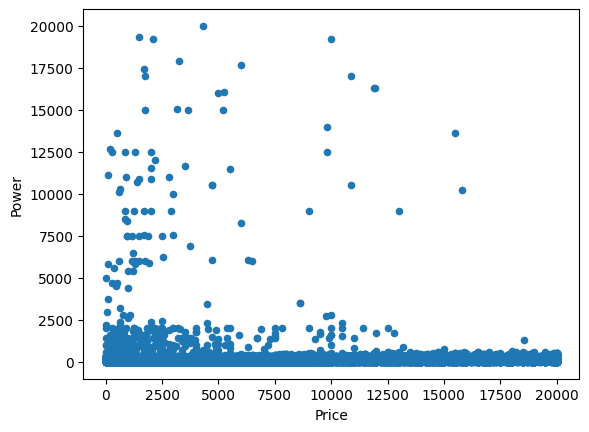

In [32]:
#Price and power (quantity-quantity)
#Let's check the dependence through correlation and table plot

corrs = data['Price'].corr(data['Power'])
print(corrs);
data.plot(x='Price', y='Power', kind='scatter');

There is a weak direct relationship between the price and power of a car.

In [33]:
#Price and model (quantity-categ)

print(data['Model'].value_counts())
#data.boxplot('Price', data.query('Model == "golf"'), figsize=(10,10))

Model
golf                  28246
other                 23706
3er                   19179
                      17521
polo                  12628
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: count, Length: 251, dtype: int64


The most popular model is golf, the number of advertisements for this model is 28,246.

In [34]:
#Let's check the third hypothesis: the average price of the most popular golf cars and the average price of other cars differ.
#Let's formulate the null hypothesis H₀ (must be represented with an equal sign): the average price of cars in the first group is equal to the average price of cars in the second group.
#Let's formulate an alternative hypothesis (it will be two-sided) H₁: the average price of cars of the first type is not equal (more or less) to the average price of cars of the second group.
#Let's conduct a test for the hypothesis about the equality of two general populations.


data_golf = data.query('Model == "golf"')['Price']
data_other = data.query('Model != "golf"')['Price']

print('Price variation of the cars (Golf brand):', np.var(data_golf))
print('Price variation of other cars:', np.var(data_other))

print('Standard deviation of the Golf cars prices:', np.std(data_golf))
print('Standard deviation of other cars prices:', np.std(data_other))

alpha = .01 

results = st.ttest_ind(data_golf, data_other, equal_var = False) 

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the hull hypothesis")
    
print('Mean prices of the Golf cars:', data_golf.mean())
print('Mean prices of other cars:', data_other.mean())

Price variation of the cars (Golf brand): 19118364.170283865
Price variation of other cars: 20492997.162580155
Standard deviation of the Golf cars prices: 4372.4551650398735
Standard deviation of other cars prices: 4526.9191689912195
p-value: 1.5199440257525924e-24
We reject the null hypothesis
Mean prices of the Golf cars: 4299.323727253416
Mean prices of other cars: 4578.061785905685


With 99% probability we can say that the average price for golf cars is not equal to the average price for other cars. The price dispersion for the second group is higher, the standard deviation is higher by approximately 150 euros. The average price for golf cars is about 4300 euros, for other cars - about 4600 euros.

-0.35050396907513165


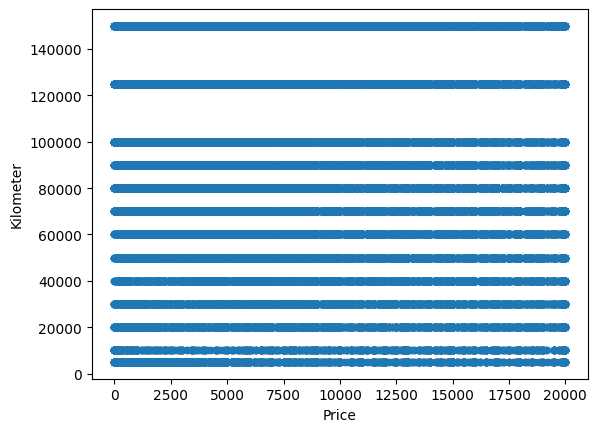

In [35]:
#Price and mileage (quantity-quantity)

corrs = data['Kilometer'].corr(data['Price'])
print(corrs)
data.plot.scatter(x='Price', y='Kilometer');

There is an inverse weak relationship between the price and mileage of a car.

FuelType
petrol      240221
gasoline     97167
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: count, dtype: int64


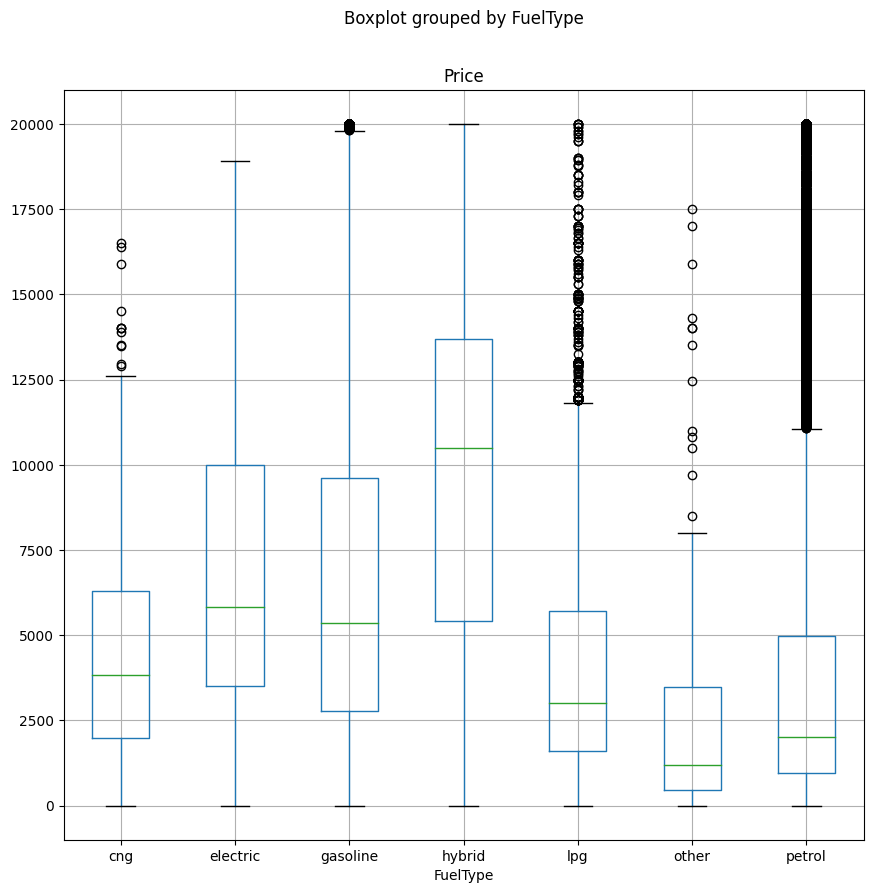

In [36]:
#Price and fuel type (quantity-categ)

print(data['FuelType'].value_counts())

data.boxplot('Price', 'FuelType', figsize=(10,10));

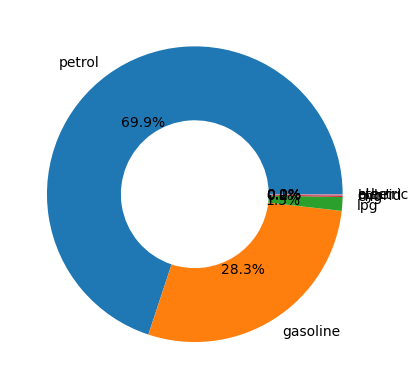

In [37]:
vals = [240221, 97167, 5166, 554, 227, 170, 88]
labels = ["petrol", "gasoline", "lpg", "cng", "hybrid", "other", "electric"]
fig, ax = plt.subplots();
ax.pie(vals, labels=labels, autopct='%1.1f%%', wedgeprops=dict(width=0.5));

Cars with petrol fuel predominate (about 70%). The median price for such cars (less than 2,500 euros) is lower than almost all other groups.

In [38]:
#Let's check the fourth hypothesis: the average price of the most popular cars with petrol fuel and the average price of other cars differ.
#Let's formulate the null hypothesis H₀ (must be represented with an equal sign): the average price of cars in the first group is equal to the average price of cars in the second group.
#Let's formulate an alternative hypothesis (it will be two-sided) H₁: the average price of cars of the first type is not equal (more or less) to the average price of cars of the second group.
#Let's conduct a test for the hypothesis about the equality of two general populations.

data_petrol = data.query('FuelType == "petrol"')['Price']
data_other = data.query('FuelType != "petrol"')['Price']

print('The price variation of the petrol cars:', np.var(data_petrol))
print('The price variation of other cars:', np.var(data_other))

print('Standard deviation of the petrol cars prices:', np.std(data_petrol))
print('Standard deviation of other cars prices:', np.std(data_other))

alpha = .01 

results = st.ttest_ind(data_petrol, data_other, equal_var = False) 

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
    
print('Mean of the prices for the petrol cars:', data_petrol.mean())
print('Mean of the prices for other cars:', data_other.mean())


The price variation of the petrol cars: 16519629.538688837
The price variation of other cars: 23694119.585045766
Standard deviation of the petrol cars prices: 4064.4347133013266
Standard deviation of other cars prices: 4867.660586467155
p-value: 0.0
Reject the null hypothesis
Mean of the prices for the petrol cars: 3697.8995966214443
Mean of the prices for other cars: 6547.262401810935


To confirm the boxplot graph, with a 99% probability we can say that the average price of cars with petrol fuel is not equal to the average price of other cars. The dispersion is significantly lower for the first group, the standard deviation is lower by almost 800 euros. The average price of cars with petrol is about 3,700 euros, which is lower than the value for the second group by approximately 2,850 euros.

In [39]:
#Price and brand (quantity-brand)

print(data['Brand'].value_counts())


Brand
volkswagen        74412
opel              38530
bmw               35809
mercedes_benz     31357
audi              28574
ford              24457
renault           17389
peugeot           10781
fiat               9332
seat               6718
mazda              5465
skoda              5435
smart              5171
citroen            5029
nissan             4807
toyota             4536
hyundai            3533
mini               3165
volvo              3122
mitsubishi         2927
sonstige_autos     2847
honda              2715
kia                2407
suzuki             2272
alfa_romeo         2234
chevrolet          1704
chrysler           1368
dacia               890
daihatsu            775
subaru              735
porsche             734
jeep                658
land_rover          534
daewoo              533
saab                515
trabant             498
jaguar              493
rover               462
lancia              457
lada                213
Name: count, dtype: int64


The most popular car brand is Volkswagen (about 75,000 ads).

In [40]:
#Let's check the fifth hypothesis: the average price of the most popular Volkswagen cars and the average price of other cars differ.
#Let's formulate the null hypothesis H₀ (must be represented with an equal sign): the average price of cars in the first group is equal to the average price of cars in the second group.
#Let's formulate an alternative hypothesis (it will be two-sided) H₁: the average price of cars of the first type is not equal (more or less) to the average price of cars of the second group.
#Let's conduct a test for the hypothesis about the equality of two general populations.

data_volkswagen = data.query('Brand == "volkswagen"')['Price']
data_other = data.query('Brand != "volkswagen"')['Price']

print('The price variation of the most popular cars Volkswagen:', np.var(data_volkswagen))
print('The price variation of other cars:', np.var(data_other))

print('Standard deviation of cars prices in the first group:', np.std(data_volkswagen))
print('Standard deviation of cars prices in the second group:', np.std(data_other))

alpha = .01 

results = st.ttest_ind(data_volkswagen, data_other, equal_var = False) 

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
    
print('The mean price of Volkswagen cars:', data_volkswagen.mean())
print('The mean price of other cars:', data_other.mean())

The price variation of the most popular cars Volkswagen: 19930386.73882725
The price variation of other cars: 20511610.408302616
Standard deviation of cars prices in the first group: 4464.3461714821415
Standard deviation of cars prices in the second group: 4528.974542686525
p-value: 0.1532339654763963
We can't reject the null hypothesis
The mean price of Volkswagen cars: 4534.393538676558
The mean price of other cars: 4560.884520081284


With a 99% probability we can say that the average price of Volkswagen cars is close in value to the average price of the group of other cars. The difference in variances is not that high, the difference in standard deviations is only about 65 euros. The average price of Volkswagen cars is about 4534, other cars are about 4560, the difference is less than 30 euros.

Repaired
no     243679
        65866
yes     34048
Name: count, dtype: int64


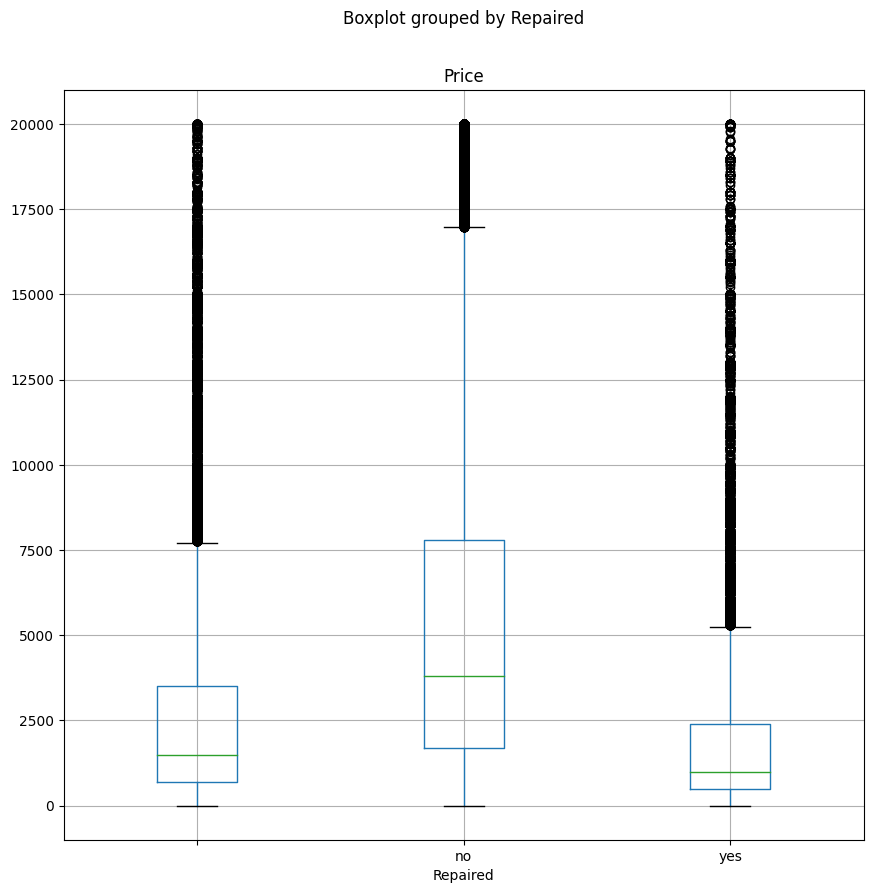

In [41]:
#Price and the repair factor (quantity-categ)

print(data['Repaired'].value_counts())


data.boxplot('Price', 'Repaired', figsize=(10,10));

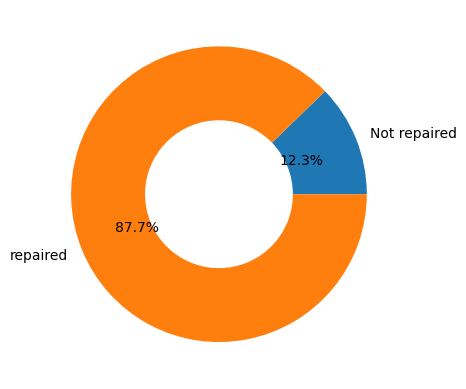

In [42]:
vals = [34048, 243679]
labels = ["Not repaired", "repaired"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', wedgeprops=dict(width=0.5));

About 88% of advertisements are for cars with repairs and about 12% are for cars without repairs. The median price for cars with repairs is higher than the median price for cars without repairs.

In [43]:
#Let's check the sixth hypothesis: the average price of cars with repair and the average price of cars without repair differ.
#Let's formulate the null hypothesis H₀ (must be represented with an equal sign): the average price of cars in the first group is equal to the average price of cars in the second group.
#Let's formulate an alternative hypothesis (it will be two-sided) H₁: the average price of cars of the first type is not equal (more or less) to the average price of cars of the second group.
#Let's conduct a test for the hypothesis about the equality of two general populations.

data_repaired = data.query('Repaired == "yes"')['Price']
data_notrepaired = data.query('Repaired == "no"')['Price']

print('The price variation of the cars that were repaired:', np.var(data_repaired))
print("The price variation of the cars that weren't repaired:", np.var(data_notrepaired))

print('Standard deviation of the prices of the cars that were repaired:', np.std(data_repaired))
print("Standard deviation of the prices of the cars that weren't repaired:", np.std(data_notrepaired))

alpha = .01

results = st.ttest_ind(data_repaired, data_notrepaired, equal_var = False) 

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")
    
print('The mean price of the repaired cars:', data_repaired.mean())
print('The mean price of the cars without a repair:', data_notrepaired.mean())

The price variation of the cars that were repaired: 7322257.873467496
The price variation of the cars that weren't repaired: 22227933.98854842
Standard deviation of the prices of the cars that were repaired: 2705.9670865454914
Standard deviation of the prices of the cars that weren't repaired: 4714.6509932919125
p-value: 0.0
Reject the null hypothesis
The mean price of the repaired cars: 2028.788005169173
The mean price of the cars without a repair: 5372.479118020018


With 99% probability we can say that the average price for cars with/without repair differs. The variance in several times higher for the first group, the standard deviation is higher by almost 2000 euros. The average price for cars with repair is about 5,373 euros, without repair - about 2,029 euros.

During the EDA, we processed gaps and duplicates, checked the relationship of independent indicators with the target feature, and removed uninformative data, including rows with a zero value of the target feature.

# 2. Training

In [44]:
#let's split the data into the train and test parts

features_train, features_test, target_train, target_test = train_test_split(
    data.drop('Price', axis=1), data.Price, test_size=0.25, random_state=12345)

print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)


(257694, 8) (85899, 8) (257694,) (85899,)


In [45]:
#Let's bring numerical characteristics to scale 1

numeric = ['Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
54218,sedan,manual,0.701771,5er,0.577495,petrol,bmw,
179462,bus,auto,-0.627929,voyager,0.577495,lpg,chrysler,
208850,small,auto,-0.288431,corsa,0.577495,petrol,opel,no
340750,small,manual,-0.299748,twingo,-1.555553,petrol,renault,no
22569,sedan,manual,-0.288431,ibiza,0.577495,petrol,seat,no


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343593 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Price        343593 non-null  int64 
 1   VehicleType  343593 non-null  object
 2   Gearbox      343593 non-null  object
 3   Power        343593 non-null  int64 
 4   Model        343593 non-null  object
 5   Kilometer    343593 non-null  int64 
 6   FuelType     343593 non-null  object
 7   Brand        343593 non-null  object
 8   Repaired     343593 non-null  object
dtypes: int64(3), object(6)
memory usage: 26.2+ MB


In [47]:
#the categorical features

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Using Gridsearch, we will select the best catboostregressor model, setting the depth to 5, 10 and 15, as well as the training level to 0.1 and 1.

In [48]:
%%time
model_cat = CatBoostRegressor(cat_features=cat_features, iterations=50, verbose=15)
param_grid = {'learning_rate': [0.1, 1], 'depth': [5, 10, 15]} 

gs = GridSearchCV(estimator=model_cat, param_grid = param_grid, cv = 3, scoring='neg_mean_squared_error')
gs.fit(features_train, target_train)

print(gs.best_params_)
print(gs.best_estimator_)

0:	learn: 4299.5876015	total: 103ms	remaining: 5.06s
15:	learn: 2950.2721955	total: 694ms	remaining: 1.48s
30:	learn: 2712.9752815	total: 1.25s	remaining: 765ms
45:	learn: 2641.9199652	total: 1.79s	remaining: 156ms
49:	learn: 2627.5659151	total: 1.94s	remaining: 0us
0:	learn: 4296.8688172	total: 55.7ms	remaining: 2.73s
15:	learn: 2947.7502185	total: 631ms	remaining: 1.34s
30:	learn: 2706.9937697	total: 1.18s	remaining: 726ms
45:	learn: 2630.8459230	total: 1.73s	remaining: 150ms
49:	learn: 2618.0721362	total: 1.88s	remaining: 0us
0:	learn: 4295.6590261	total: 52.9ms	remaining: 2.59s
15:	learn: 2950.2687454	total: 628ms	remaining: 1.33s
30:	learn: 2719.2586996	total: 1.18s	remaining: 726ms
45:	learn: 2645.8768665	total: 1.74s	remaining: 152ms
49:	learn: 2633.7215290	total: 1.89s	remaining: 0us
0:	learn: 3189.7785864	total: 53.4ms	remaining: 2.62s
15:	learn: 2564.8710039	total: 636ms	remaining: 1.35s
30:	learn: 2454.9484116	total: 1.18s	remaining: 723ms
45:	learn: 2397.2695949	total: 1.78

Let's train the best model and check the training time

In [49]:
%%time
model_cat = CatBoostRegressor(depth= 15, iterations=50, verbose=15, learning_rate=1)
model_cat.fit(features_train, target_train, cat_features=cat_features)

0:	learn: 2892.3605675	total: 165ms	remaining: 8.1s
15:	learn: 2055.6555297	total: 5.65s	remaining: 12s
30:	learn: 1922.7828074	total: 11.1s	remaining: 6.81s
45:	learn: 1818.5066241	total: 16.6s	remaining: 1.45s
49:	learn: 1800.1363251	total: 18.1s	remaining: 0us
CPU times: user 49.5 s, sys: 3.54 s, total: 53 s
Wall time: 18.5 s


In [50]:
# let's transform categorical features into a special type category for the lgbmregressor model

features_train[['FuelType', 'Gearbox', 'Brand', 'Model', 'Repaired', 'VehicleType']] = features_train[['FuelType', 'Gearbox', 'Brand', 'Model', 'Repaired', 'VehicleType']].astype('category')

categorical_feature=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Let's use the gridsearch method again to find the best parameters for the lgbmregressor model, suggesting depths of 5, 10 and 15, learning levels of 0.1 and 1, number of leaves 2 and 31.

In [51]:
%%time
model_lgbm = lgb.LGBMRegressor()

param_grid = {
              'learning_rate': [0.1, 1], 
              'max_depth': [5, 10, 15],
              'num_leaves': [2, 31]
             } 

grid = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, cv = 3, scoring='neg_mean_squared_error', refit = True, verbose = 15)
grid.fit(features_train, target_train)

print(grid.best_params_)
print(grid.best_estimator_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START learning_rate=0.1, max_depth=5, num_leaves=2...............
[CV 1/3; 1/12] END learning_rate=0.1, max_depth=5, num_leaves=2;, score=-8434494.228 total time=   0.7s
[CV 2/3; 1/12] START learning_rate=0.1, max_depth=5, num_leaves=2...............
[CV 2/3; 1/12] END learning_rate=0.1, max_depth=5, num_leaves=2;, score=-8478201.321 total time=   0.6s
[CV 3/3; 1/12] START learning_rate=0.1, max_depth=5, num_leaves=2...............
[CV 3/3; 1/12] END learning_rate=0.1, max_depth=5, num_leaves=2;, score=-8454178.230 total time=   0.6s
[CV 1/3; 2/12] START learning_rate=0.1, max_depth=5, num_leaves=31..............
[CV 1/3; 2/12] END learning_rate=0.1, max_depth=5, num_leaves=31;, score=-5495064.059 total time=   1.7s
[CV 2/3; 2/12] START learning_rate=0.1, max_depth=5, num_leaves=31..............
[CV 2/3; 2/12] END learning_rate=0.1, max_depth=5, num_leaves=31;, score=-5499346.448 total time=   1.8s
[CV 3/3; 2/1

Again let's train a model based on the selected parameters above and check the speed of operation

In [52]:
%%time
lgbm_model = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=1, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

lgbm_model.fit(features_train, target_train, categorical_feature=categorical_feature)

/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: user 3.32 s, sys: 765 ms, total: 4.09 s
Wall time: 2.11 s


LGBMRegressor(learning_rate=1, max_depth=15, silent=True)

We divided the data into training and testing sets. Using Gridsearch, we selected the best parameters for the CatBoostRegressor and LGBMRegressor models. The best model training time was obtained for the second model (38.5 sec) versus the first (1m 25 sec).

# 3. Testing

Let's make model predictions and check the forecast time.

In [53]:
%%time
predicted_test_cat = model_cat.predict(features_test)

CPU times: user 144 ms, sys: 15.8 ms, total: 160 ms
Wall time: 139 ms


In [54]:
print("RMSE CatBoost:", np.sqrt(mean_squared_error(target_test, predicted_test_cat)))

RMSE CatBoost: 2182.512550384783


In [55]:
features_test[['FuelType', 'Gearbox', 'Brand', 'Model', 'Repaired', 'VehicleType']] = features_test[['FuelType', 'Gearbox', 'Brand', 'Model', 'Repaired', 'VehicleType']].astype('category')
categorical_feature=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [56]:
%%time
predicted_test_lgbm = lgbm_model.predict(features_test)

CPU times: user 491 ms, sys: 0 ns, total: 491 ms
Wall time: 131 ms


In [57]:
print("RMSE LightGBM:", np.sqrt(mean_squared_error(target_test, predicted_test_lgbm)))

RMSE LightGBM: 2189.5622243023245


In terms of the speed of making a forecast, on the contrary, the best forecast value was obtained for the first model (399 ms versus 746 ms). The best value of model quality was obtained for the first CatBoostRegressor model (RMSE error value of about 2183), for the second model - about 2190.

During the work carried out, we analyzed the input data, processed duplicates, removed unnecessary information, and conducted a small exploratory analysis. In addition, we built CatBoostRegressor and LGBMRegressor models, having previously selected the best parameters for them. A smaller error value and less time spent on prediction were obtained for the first model, but for the second model the training time of the model itself was better.